In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  

In [2]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [3]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [4]:
# sampler = TrainConfig.make_diffusion_conf().make_sampler()

TypeError: make_diffusion_conf() missing 1 required positional argument: 'self'

In [8]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False);
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


In [9]:
# data = conf.make_dataset()
# batch = data[10]['img'][None]

In [10]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
# batch = data[1]['img'][None]

In [11]:
batch = data[3]['img'][None]

In [12]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

In [13]:
import numpy as np
np.shape(cond)

torch.Size([1, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


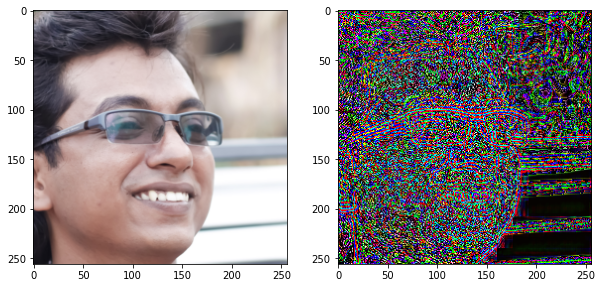

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

In [15]:
print(CelebAttrDataset.id_to_cls)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [16]:
cls_id = CelebAttrDataset.cls_to_id['Male']

In [17]:
def hy_latent(latent_np):
    hy_latent = torch.from_numpy(np.array([latent_np]))
#     hy_latent = torch.tensor(latent_np,requires_grad=True)
    hy_latent = hy_latent.to('cuda').float()
    return hy_latent

np.random.seed(50)
random_z = np.random.rand(1, 512)
random_z = hy_latent(random_z)

In [31]:
cond2 = cls_model.normalize(cond)
cond2 = cond2 + 0.5 * math.sqrt(512) * F.normalize(cls_model.classifier.weight[cls_id][None, :], dim=1)
cond2 = cond2+ 2*random_z[0]
cond2 = cls_model.denormalize(cond2)

In [19]:
np.shape(random_z[0])

torch.Size([1, 512])

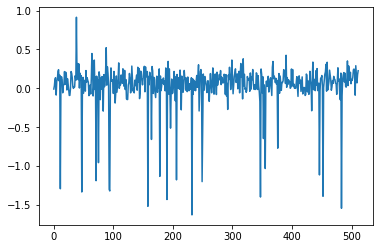

In [20]:
xp = np.arange(0,512,1)
plt.plot(xp,cond2.cpu().detach().numpy()[0])

In [28]:
face_emb = hy_latent(emb[0])
face_normalize = (face_emb+cond2)*0.8

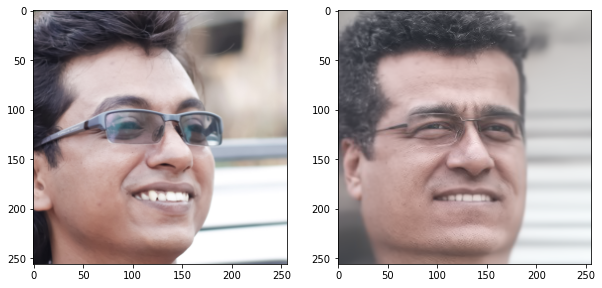

In [32]:
import matplotlib.pyplot as plt
# torch.manual_seed(1)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
img = model.render(xT, cond2, T=100)
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(img[0].permute(1, 2, 0).cpu())
# plt.savefig('imgs_manipulated/compare.png')

In [18]:
from torchvision.utils import *
save_image(img[0], 'imgs_manipulated/Arc_test/output.png')

In [57]:
np.shape(face_emb)

torch.Size([1, 1, 512])

In [ ]:
def _calc_emb_single(self, img):
    if isinstance(img, str):
        img = cv2.imread(img)
        if img is None:
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), img)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (112, 112))
    img = img.astype(np.float32) / 255.
    if len(img.shape) == 3:
        img = np.expand_dims(img, 0)
    self.interpreter.set_tensor(self.input_details[0]['index'], img)
    self.interpreter.invoke()
    output_data = self.interpreter.get_tensor(self.output_details[0]['index'])

    emb = l2_norm(output_data)
    return emb[0]

In [23]:
import cv2
from arcface.lib.utils import l2_norm
import tensorflow as tf
from astropy.utils.data import download_file

tflite_path = download_file("https://www.digidow.eu/f/datasets/arcface-tensorflowlite/model.tflite", cache=True)
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

img = cv2.imread("imgs_manipulated/Arc_test/output.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (112, 112))
img = img.astype(np.float32) / 255.
if len(img.shape) == 3:
    img = np.expand_dims(img, 0)
interpreter.set_tensor(input_details[0]['index'], img)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

emb = l2_norm(output_data)

2023-01-05 13:09:31.541042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 13:09:31.700795: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-05 13:09:32.358790: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joshua/anaconda3/envs/proj0/lib/python3.9/site-packages/cv2/../../lib64:/usr/loca

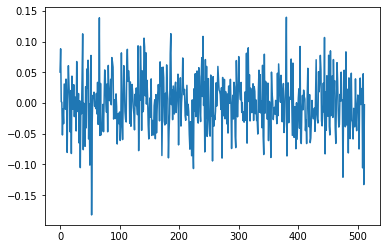

In [24]:
xp = np.arange(0,512,1)
plt.plot(xp,emb[0])

In [33]:
from arcface import ArcFace
face_rec = ArcFace.ArcFace()
emb1 = face_rec.calc_emb("imgs_manipulated/Arc_test/output.png")
emb2 = face_rec.calc_emb("/home/joshua/Projects/dataset/00000/00009.png")
face_rec.get_distance_embeddings(emb1, emb2)
# dist_ID_AS = 1-cosin_metric(emb1, emb2)
# print(dist_ID_AS)

1.091261

AttributeError: 'EasyDict' object has no attribute 'make_eval_diffusion_conf'

## ArcFace loading

In [20]:
from InsightFace_Pytorch.config import get_config
from InsightFace_Pytorch.mtcnn import MTCNN
from InsightFace_Pytorch.Learner import face_learner
from InsightFace_Pytorch.utils_insightface import load_facebank, draw_box_name, prepare_facebank
from InsightFace_Pytorch.model import Backbone
from torchvision import transforms as transforms
from InsightFace_Pytorch.arcface_torch.backbones import get_model

In [27]:
def cosin_metric(x1, x2):
    return torch.dot(x1, x2) / (torch.linalg.norm(x1) * torch.linalg.norm(x2))

In [21]:
conf = get_config(False)
model_arc = Backbone(conf.net_depth, conf.drop_ratio, conf.net_mode).to(conf.device)
save_path = "./InsightFace_Pytorch/work_space/models/model_ir_se50.pth"
model_arc.load_state_dict(torch.load(save_path),strict=True)
model_arc.eval()

Backbone(
  (input_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=64)
  )
  (output_layer): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.6, inplace=False)
    (2): Flatten()
    (3): Linear(in_features=25088, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (body): Sequential(
    (0): bottleneck_IR_SE(
      (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
      (res_layer): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): PReLU(num_parameters=64)
        (3)

In [28]:
face_pool = torch.nn.AdaptiveAvgPool2d((112, 112))  # resize function for torch tensor (112,112)
image_arc_S = face_pool(ori).to(device)
emb_S = model_arc(image_arc_S)
S = emb_S.squeeze(0)
S = S/torch.linalg.norm(S)

image_arc_A = face_pool(img).to(device)
emb_A = model_arc(image_arc_A)
A = emb_A.squeeze(0)
A = A/torch.linalg.norm(A)

dist_ID_AS = 1-cosin_metric(A, S)
print(dist_ID_AS)

tensor(0.5349, device='cuda:0', grad_fn=<RsubBackward1>)


tensor([[[[0.7055, 0.7143, 0.7228,  ..., 0.8253, 0.8255, 0.8265],
          [0.7076, 0.7150, 0.7259,  ..., 0.8184, 0.8170, 0.8171],
          [0.7130, 0.7259, 0.7365,  ..., 0.8097, 0.8082, 0.8063],
          ...,
          [0.3017, 0.2983, 0.2952,  ..., 0.9450, 0.9445, 0.9458],
          [0.2992, 0.2960, 0.2943,  ..., 0.9188, 0.9220, 0.9233],
          [0.3002, 0.2977, 0.2958,  ..., 0.8924, 0.8913, 0.8897]],

         [[0.6822, 0.6921, 0.7057,  ..., 0.8175, 0.8151, 0.8169],
          [0.6923, 0.7005, 0.7140,  ..., 0.8085, 0.8078, 0.8076],
          [0.6978, 0.7026, 0.7138,  ..., 0.8006, 0.7998, 0.7981],
          ...,
          [0.2852, 0.2828, 0.2802,  ..., 0.9549, 0.9562, 0.9592],
          [0.2836, 0.2813, 0.2794,  ..., 0.9321, 0.9327, 0.9348],
          [0.2840, 0.2810, 0.2795,  ..., 0.9050, 0.9042, 0.9028]],

         [[0.6668, 0.6770, 0.6878,  ..., 0.7977, 0.7968, 0.7972],
          [0.6715, 0.6825, 0.6938,  ..., 0.7903, 0.7882, 0.7877],
          [0.6782, 0.6881, 0.6999,  ..., 0

In [24]:
np.shape(S)

torch.Size([512])

In [67]:
!python run_celeba64.py

conf: celeba64d2c_autoenc
Global seed set to 0
Model params: 86.63 M
ckpt path: checkpoints/celeba64d2c_autoenc/last.ckpt
Traceback (most recent call last):
  File "/home/joshua/Projects/diffae/run_celeba64.py", line 9, in <module>
    train(conf, gpus=gpus)
  File "/home/joshua/Projects/diffae/experiment.py", line 916, in train
    plugins.append(DDPPlugin(find_unused_parameters=False))
  File "/home/joshua/anaconda3/envs/proj0/lib/python3.9/site-packages/pytorch_lightning/_graveyard/training_type.py", line 45, in _ttp_constructor
    raise NotImplementedError(
NotImplementedError: The `pl.plugins.DDPPlugin` class was deprecated in v1.6 and is no longer supported as of v1.8. Use `pl.strategies.DDPStrategy` instead.


In [1]:
from templates import *
from templates_latent import *


gpus = [0]
conf = ffhq128_autoenc_latent()
train(conf, gpus=gpus)

Global seed set to 0


conf: ffhq128_autoenc_latent
Model params: 174.19 M
loading pretrain ... 130M
step: 1019986


/home/joshua/anaconda3/envs/proj0/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


loading latent stats ...
ckpt path: checkpoints/ffhq128_autoenc_latent/last.ckpt


/home/joshua/anaconda3/envs/proj0/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /home/joshua/Projects/diffae/checkpoints/ffhq128_autoenc_latent exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


local seed: 0
train data: 70001
val data: 70001


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | BeatGANsAutoencModel | 182 M 
1 | ema_model | BeatGANsAutoencModel | 182 M 
---------------------------------------------------
182 M     Trainable params
182 M     Non-trainable params
365 M     Total params
730.619   Total estimated model params size (MB)


on train dataloader start ...
mean: tensor(-0.0606, device='cuda:0') std: tensor(0.0755, device='cuda:0')


Training: 0it [00:00, ?it/s]

/home/joshua/anaconda3/envs/proj0/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
